
# 图像的自回归生成任务 
autogressive likelihood model

- based on  PixelCNN architecture
- and apply it to MNIST modeling
- link: https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/10-autoregressive-image-modeling.html
    - meterials: The full list of tutorials can be found at https://uvadlc-notebooks.rtfd.io.
    
基本配置
```sh
pip install --quiet "torchmetrics>=0.7, <0.12" "torchvision" "setuptools==67.4.0" "seaborn" "pytorch-lightning>=1.4, <2.0.0" "lightning>=2.0.0rc0" "torch>=1.8.1, <1.14.0" "matplotlib" "ipython[notebook]>=8.0.0, <8.12.0"
```

In [26]:
import math
import os
import urllib.request
from urllib.error import HTTPError

import lightning as L

# Imports for plotting
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from matplotlib.colors import to_rgb
from torch import Tensor
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm


In [54]:

plt.set_cmap("cividis")
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/tutorial12")

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial12/"
# Files to download
pretrained_files = ["PixelCNN.ckpt"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print("Downloading %s..." % file_url)
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n",
                e,
            )

## 无注释版本 主要思路是根据计算L1损失（随便什么损失），然后梯度反传，获取梯度图绘制感受野
def simple_show_center_recep_field(img, out):
    loss = out[0, :, img.shape[2] // 2, img.shape[3] // 2].sum()  # L1 loss for simplicity
    loss.backward(retain_graph=True)
    img_grads = img.grad.abs()
    img.grad.fill_(0)  # Reset grads
    img = img_grads.squeeze().cpu().numpy()
    fig, ax = plt.subplots(1, 2)
    _ = ax[0].imshow(img)
    ax[1].imshow(img > 0)
    show_center = img[img.shape[0] // 2, img.shape[1] // 2] == 0
    if show_center:
        center_pixel = np.zeros(img.shape + (4,))
        center_pixel[center_pixel.shape[0] // 2, center_pixel.shape[1] // 2, :] = np.array([1.0, 0.0, 0.0, 1.0])
        for i in range(2):
            ax[i].axis("off")
            if show_center:
                ax[i].imshow(center_pixel)
    ax[0].set_title("Weighted receptive field")
    ax[1].set_title("Binary receptive field")
    plt.show()
    plt.close()

Global seed set to 42


Using device cuda:0



### 图像自回归的一般思路

- 一般想法：将2d像素矩阵视为1d序列，i-th pixel被建模为前i-1个像素的条件概率分布，记为 
$$
p(x)=p(x_1...x_n) = \prod_{i=1}^n p(x_i|x_1,\cdots , x_{i-1})
$$
- 学习模型拟合上述条件概率分布：
    - 优点：学习条件概率分布比所有pixels的联合概率分布 p(x)更简单一些；
    - 缺点：自回归模型的采样很慢(low sampling), 特别对于大图像，需要h×w次前向预测全图
    - 缺点：有的任务要对image进行latent space的建模（也就是需要表征），但是**自回归模型没有特征学习的阶段**：
        - VAE和归一化流 Normalizing flows会学习一个映射，将input image -> feature vector
        - 但是自回归的条件概率拟合只是学习了一个概率函数，因此没法对两个image进行插值


#### Data representation

数据集Mnist，对每个像素使用8 bits编码（0-255）


In [ ]:
# Convert images from 0-1 to 0-255 (integers). We use the long datatype as we will use the images as labels as well
def discretize(sample):
    return (sample * 255).to(torch.long)


In [28]:
# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(), discretize])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
L.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

Global seed set to 42


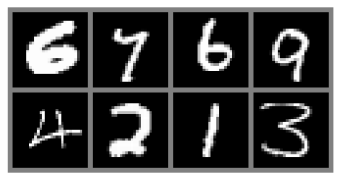

In [29]:
def show_imgs(imgs):
    num_imgs = imgs.shape[0] if isinstance(imgs, Tensor) else len(imgs)
    nrow = min(num_imgs, 4)
    ncol = int(math.ceil(num_imgs / nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128)
    imgs = imgs.clamp(min=0, max=255)
    np_imgs = imgs.cpu().numpy()
    plt.figure(figsize=(1.5 * nrow, 1.5 * ncol))
    plt.imshow(np.transpose(np_imgs, (1, 2, 0)), interpolation="nearest")
    plt.axis("off")
    plt.show()
    plt.close()


show_imgs([train_set[i][0] for i in range(8)])

### Base model: PixelCNN

- 在PixelCNN中 核心模块为**mask卷积**
- 大多数SOTA模型使用PixelCNN作为基础架构 ；还有几种变体如PixelCNN++和PixelSNAIL用于提升其性能；


#### image masking -> kernel masking

image自回归的挑战：
- 一般的基于序列的自回归模型如LSTM不适用，是由于图像的2D grids结构导致按序列生成过于低效（慢且差）；
- 因此使用CNN是自然的选择；只是需要对卷积操作进行一些改动：
    - 改动原则：在自回归的训练中，适用teacher forcing 提升模型训练效果 同时显著减少训练时间。
    - 对于图像的modeling tf实现为：使用一个训练图像作为模型的输入 获取其输出 也就是每个像素基于predecessors的预测结果
        - 因此 需要保证对特定像素的输出只由其predecessor影响，而不被future pixels影响；可以对image进行mask来实现这一点


自回归mask需要定义pixel的顺序；
- 一般的顺序为左上(upper left)到右下(bottem right)
- 对某一个pixel的预测，不能参考其true input、左边的像素和上边的像素；- 在卷积中，这意味着卷积核在处理上方的左方的input时，需要将对应weight置为0，即

mask for 5x5 kernel：
```
1 1 1 1 1
1 1 1 1 1
1 1 0 0 0 
0 0 0 0 0
0 0 0 0 0
** 注意：mask矩阵中1 表示“apply mask”
```

apply an arbitrary mask to a conv:
- 下面的`MaskedConvolution`表示一层上方+左方的卷积

In [30]:

class MaskedConvolution(nn.Module):
    def __init__(self, c_in, c_out, mask, **kwargs):
        """Implements a convolution with mask applied on its weights.

        Args:
            c_in: Number of input channels
            c_out: Number of output channels
            mask: Tensor of shape [kernel_size_H, kernel_size_W] with 0s where
                   the convolution should be masked, and 1s otherwise.
            kwargs: Additional arguments for the convolution
        """
        super().__init__()
        # For simplicity: calculate padding automatically
        kernel_size = (mask.shape[0], mask.shape[1])
        dilation = 1 if "dilation" not in kwargs else kwargs["dilation"]
        padding = tuple(dilation * (kernel_size[i] - 1) // 2 for i in range(2))
        # Actual convolution
        self.conv = nn.Conv2d(c_in, c_out, kernel_size, padding=padding, **kwargs)

        # Mask as buffer => it is no parameter but still a tensor of the module
        # (must be moved with the devices)
        self.register_buffer("mask", mask[None, None])

    def forward(self, x):
        self.conv.weight.data *= self.mask  # Ensures zero's at masked positions
        return self.conv(x)

上图这种对kernel做mask的方式会导致感受野的行为不同于之前所期望的自回归的行为；即感受野会在右上方出现blind spot

- 卷积核的感受野是四周扩散，对于5×5感受野的kernel，中间的1 1 0 0 0会导致卷到最后的 x x <pad>时，前一行的最后一列被0 覆盖，因此导致右方的上行像素无法获取用于当前像素的预测
- 因此一种改进的方法：分height mask和width mask ，从水平和竖直两个方向进行kernel mask

mask: tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


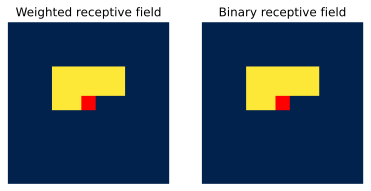

In [56]:
inp_img = torch.zeros(1, 1, 11, 11)
inp_img.requires_grad_()

# conv mask
mask = torch.zeros(5,5)

center_idn = (mask.shape[-2]//2, mask.shape[-1]//2)
# center
mask[center_idn[0],center_idn[1]] = 0
# rows
mask[:center_idn[0]][:] = 1
# the rows before
mask[center_idn[0]][:center_idn[1] ] = 1
# mask[0][0][:center_idn[0]][:center_idn[1]] = 0

print("mask:", mask)
masked_conv = MaskedConvolution(c_in=1, c_out=1, mask=mask)
masked_conv.conv.weight.data.fill_(1)
masked_conv.conv.bias.data.fill_(0)

horiz_img = masked_conv(inp_img)
simple_show_center_recep_field(inp_img, horiz_img)

- 之前所说的感受野不正确的问题 需要多叠加几层观察

Layer 1


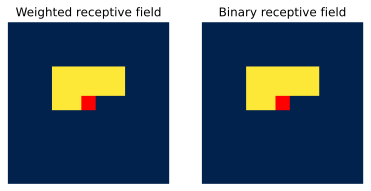

Layer 2


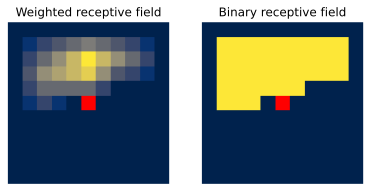

In [64]:
img = masked_conv(inp_img)
print("Layer %i" % (1))
simple_show_center_recep_field(inp_img, img)

for l_idx in range(1):
    img = masked_conv(img)
    print("Layer %i" % (l_idx + 2))
    simple_show_center_recep_field(inp_img, img)

- 需要注意上图有点问题的；后面几层的mask不应该是中间=0，会造成信息损失。

Layer 1


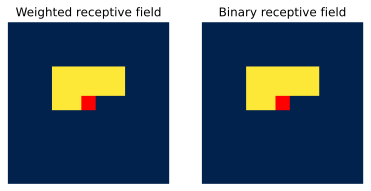

Layer 2


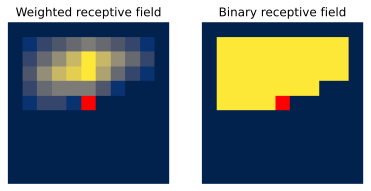

Layer 3


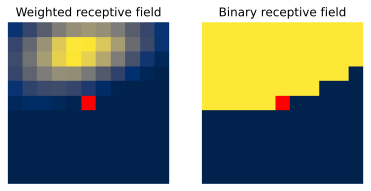

Layer 4


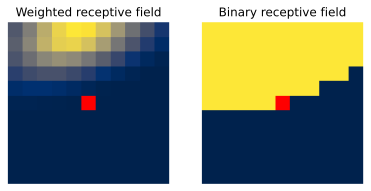

In [62]:
# conv mask
mask2 = torch.zeros(5,5)
center_idn = (mask2.shape[-2]//2, mask2.shape[-1]//2)
mask2[center_idn[0],center_idn[1]] = 1# center
mask2[:center_idn[0]][:] = 1# rows
mask2[center_idn[0]][:center_idn[1] ] = 1# the rows before

masked_conv_2 = MaskedConvolution(c_in=1, c_out=1, mask=mask2)
masked_conv_2.conv.weight.data.fill_(1)
masked_conv_2.conv.bias.data.fill_(0)

# l1
img = masked_conv(inp_img)
print("Layer %i" % (1))
simple_show_center_recep_field(inp_img, img)

for l_idx in range(3):
    img = masked_conv_2(img)
    print("Layer %i" % (l_idx + 2))
    simple_show_center_recep_field(inp_img, img)

> Although a pixel should be able to take into account all other pixels above and left of it, a stack of masked convolutions does **not allow us to look to the upper pixels on the right**. This is because the features of the pixels above, which we use for convolution, do not contain any information of the pixels on the right of the same row. If they would, we would be “cheating” and actually looking into the future. 

[2] van den Oord, A., et al. “Conditional Image Generation with PixelCNN Decoders.” In Advances in Neural Information Processing Systems 29, pp. 4790–4798 (2016). 

- vande den Oord提出了一种水平mask和垂直mask的卷积操作，如下所示；注意到新增了一个参数 mask center.
- 对特征图做卷积是必须使用center的信息的，因此mask center默认为false；但是对于自回归，第一层卷积是对input image卷积，因此第一层的mask center=True

In [65]:
class VerticalStackConvolution(MaskedConvolution):
    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        # Mask out all pixels below. For efficiency, we could also reduce the kernel
        # size in height, but for simplicity, we stick with masking here.
        mask = torch.ones(kernel_size, kernel_size)
        mask[kernel_size // 2 + 1 :, :] = 0

        # For the very first convolution, we will also mask the center row
        if mask_center:
            mask[kernel_size // 2, :] = 0

        super().__init__(c_in, c_out, mask, **kwargs)


class HorizontalStackConvolution(MaskedConvolution):
    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        # Mask out all pixels on the left. Note that our kernel has a size of 1
        # in height because we only look at the pixel in the same row.
        mask = torch.ones(1, kernel_size)
        mask[0, kernel_size // 2 + 1 :] = 0

        # For the very first convolution, we will also mask the center pixel
        if mask_center:
            mask[0, kernel_size // 2] = 0

        super().__init__(c_in, c_out, mask, **kwargs)

### 可视化感受野
Visualizing the receptive field

- 为了验证我们的掩码卷积的实现，我们可以可视化卷积得到的感受野。
- 期望的结果：
    - 1、随着卷积层数的增加，感受野在垂直和水平方向上都在增长，**没有盲点的问题**。
    - 2、感受野：可以通过**反向传播输出的任意损失**来经验地测量特定像素相对于输入的特征。
    
实现如下：

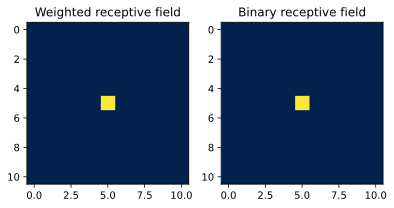

In [66]:

def show_center_recep_field(img, out):
    """Calculates the gradients of the input with respect to the output center pixel, and visualizes the overall
    receptive field.

    Args:
        img: Input image for which we want to calculate the receptive field on.
        out: Output features/loss which is used for backpropagation, and should be
              the output of the network/computation graph.
    """
    # 梯度：Determine gradients
    loss = out[0, :, img.shape[2] // 2, img.shape[3] // 2].sum()  # L1 loss for simplicity
    
    # 将`retain_graph`开启：Retain graph as we want to stack multiple layers and show the receptive field of all of them
    loss.backward(retain_graph=True)

    # 函数退出后下次可以再次调用正确地计算梯度
    img_grads = img.grad.abs()
    img.grad.fill_(0)  # Reset grads

    # Plot receptive field
    img = img_grads.squeeze().cpu().numpy()
    fig, ax = plt.subplots(1, 2)
    _ = ax[0].imshow(img)
    ax[1].imshow(img > 0)

    
    # Mark the center pixel in red if it doesn't have any gradients (should be
    # the case for standard autoregressive models)

    # if mask_center == True, image center will be zero. Then set the pixel red.
    show_center = img[img.shape[0] // 2, img.shape[1] // 2] == 0
    if show_center:
        center_pixel = np.zeros(img.shape + (4,))
        center_pixel[center_pixel.shape[0] // 2, center_pixel.shape[1] // 2, :] = np.array([1.0, 0.0, 0.0, 1.0])
        for i in range(2):
            ax[i].axis("off")
            if show_center:
                ax[i].imshow(center_pixel)
                
    ax[0].set_title("Weighted receptive field")
    ax[1].set_title("Binary receptive field")
    plt.show()
    plt.close()

inp_img = torch.zeros(1, 1, 11, 11)
inp_img.requires_grad_()
# test
show_center_recep_field(inp_img, out=inp_img)

#### 感受野可视化2：水平卷积,垂直卷积
- 卷积参数：
    - `mask_center = True`
    - 只看到同一行的左边像素
- 输入图像：11 x 11，然后计算输出的中心像素(feature map)的损失
- 权重初始化：1
- 偏置初始化：0
- 通道数：1

可视化结果：
- 水平卷积，只有同一行左侧的pixel可以看到；kernel=3，因此感受野只有左边一个像素；
- 垂直卷积：卷积核=3，上一行的所有3个像素都可以感知到。

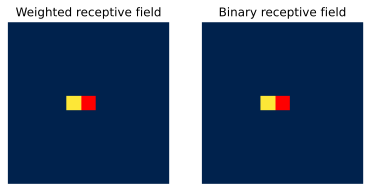

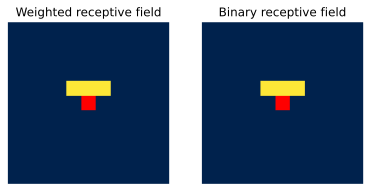

In [74]:
inp_img = torch.zeros(1, 1, 11, 11) # batch=1，单通道1，大小11×11
inp_img.requires_grad_()

horiz_conv = HorizontalStackConvolution(c_in=1, c_out=1, kernel_size=3, mask_center=True)
horiz_conv.conv.weight.data.fill_(1);horiz_conv.conv.bias.data.fill_(0)
horiz_img = horiz_conv(inp_img)
show_center_recep_field(inp_img, horiz_img)

vert_conv = VerticalStackConvolution(c_in=1, c_out=1, kernel_size=3, mask_center=True)
vert_conv.conv.weight.data.fill_(1);vert_conv.conv.bias.data.fill_(0)
vert_img = vert_conv(inp_img)
show_center_recep_field(inp_img, vert_img)

- 上图中，由于mask_center=True，因此中心是0，绘制中心点为red pixel

#### 感受野可视化3:水平卷积+竖直卷积, stack

- 两个卷积图像**直接相加**可视化感受野
- 实际上用的时候也是两个卷积分别执行再相加，而**不是简单的嵌套顺序执行**

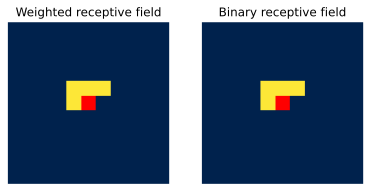

In [75]:
horiz_img = vert_img + horiz_img
show_center_recep_field(inp_img, horiz_img)

如果我们堆叠多个水平和垂直卷积，我们需要考虑两个方面:

1. 在接下来的卷积中，中心不应该再被掩盖，因为像素位置的特征已经独立于它的实际值-> 由于特征图对于每个pixel 不包含原本的像素了
2. 对于第一层和所有的feature map：垂直卷积都不允许作用于经过水平卷积的特征: i.e. 必须先垂直后水平

>在水平卷积的特征图中，一个像素包含关于左侧所有“真实”像素的信息。如果我们应用一个垂直卷积，它也使用右边的特征，将接受域扩展到我们想要阻止的真实输入。因此，**特征图的合并**只能用于**水平卷积**。使用这个，我们可以用下面的方式来堆叠卷积。

我们有两个特征stream分支:
- 一个用于垂直stack，另一个用于水平stack。
    - 水平卷积可以对之前水平卷积和垂直卷积的特征进行**融合**
    - 垂直卷积只将自己之前的特征作为输入-> 纯上方的信息

- 简洁起见：将每一层的水平和垂直输出特征简单相加（可以设计别的融合策略），获取最终输出特征计算损失

4个连续层的实现如下所示。注意，我们从上面使用mask_center=True重用其他卷积中的特性。

Layer 1


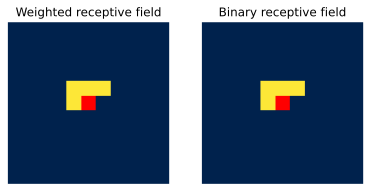

Layer 2


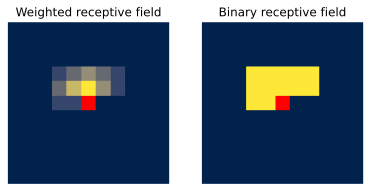

Layer 3


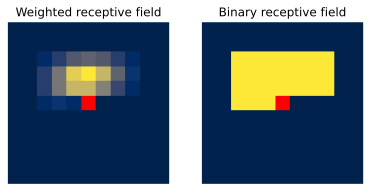

Layer 4


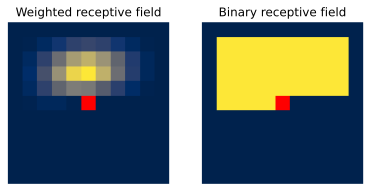

Layer 5


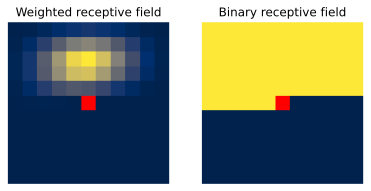

In [76]:
# Initialize convolutions with equal weight to all input pixels
horiz_conv = HorizontalStackConvolution(c_in=1, c_out=1, kernel_size=3, mask_center=False)
horiz_conv.conv.weight.data.fill_(1)
horiz_conv.conv.bias.data.fill_(0)
vert_conv = VerticalStackConvolution(c_in=1, c_out=1, kernel_size=3, mask_center=False)
vert_conv.conv.weight.data.fill_(1)
vert_conv.conv.bias.data.fill_(0)

img = horiz_img
print("Layer %i" % (1))
show_center_recep_field(inp_img, img)
# 简单使用相同权重的卷积核重复4 layers
# 实际中肯定得用不同的卷积核。
for l_idx in range(4):
    # 垂直分支: 垂直卷积单独stack
    vert_img = vert_conv(vert_img)
    # 融合分支: 水平卷积可以叠加垂直信息
    img = horiz_conv(img) + vert_img
    print("Layer %i" % (l_idx + 2))
    show_center_recep_field(inp_img, img)

### summary

- 对kernel进行一次mask：上方+左方 -> 异常的感受野
- 对kernel进行两种mask，两种卷积核 -> 符合预期的感受野

In [77]:
del inp_img, horiz_conv, vert_conv

## Gated PixelCNN

在下一步中，我们将使用mask卷积来构建一个完整的自回归模型，称为Gated PixelCNN。原始PixelCNN和Gated PixeICNN之间的区别是使用单独的水平和垂直堆栈。

然而，在文献中，你经常看到人们将Gated PixelCNN简称为“PixelCNN”。因此，在下面，如果我们说“PixelCNN”，我们通常指的是Gated版本

Q: “Gated”在模型名称中指的是什么

#### Gated Convolutions

- 之前可视化感受野，我们假设了一个非常简化的垂直和水平卷积堆栈。
- 显然，有更复杂的方法来做到这一点，PixelCNN使用了**Gated conv**。

具体来说，PixelCNN中的门控卷积块看起来如下(图源- Aaron van den Oord et al.):

![](https://uvadlc-notebooks.readthedocs.io/en/latest/_images/PixelCNN_GatedConv.svg
)

- 左边路径为垂直堆栈(N × N卷积相应被屏蔽)，右边路径为水平堆栈。门控卷积是通过两倍大的输出通道来实现的，并通过tanh和sigmoid的元素相乘来组合它们。对于线性层，我们可以将门控激活单元表示为:
$$
y=\tanh(W_f x)\bigodot \sigma(W_g x)
$$
- 为了简单起见，忽略了偏差，线性层分为两部分，Wf和Wg。这个概念类似于LSTM中的输入和调制门，并且已经在许多其他体系结构中使用。这种门控激活背后的主要动机是，它可能允许建模更复杂的交互并简化学习。但是在任何其他体系结构中，**这主要是一种设计选择，可以被认为是超参数**。



除了门控卷积，我们还看到水平堆栈使用residual connection，而垂直堆栈不使用。这是因为我们使用水平堆栈的输出进行预测。垂直堆栈中的每个卷积也接收到一个强梯度信号，因为它距离residual connection只有两个1 x 1卷积，并且不需要对所有早期层进行另一个residual connection。

In [108]:

class GatedMaskedConv(nn.Module):

    def __init__(self, c_in, **kwargs):
        """
        Gated Convolution block implemented the computation graph shown above.
        """
        super().__init__()

        # 使用Gated  conv的策略代替加法进行融合
        self.conv_vert = VerticalStackConvolution(c_in, c_out=2*c_in, **kwargs)
        self.conv_horiz = HorizontalStackConvolution(c_in, c_out=2*c_in, **kwargs)
        self.conv_vert_to_horiz = nn.Conv2d(2*c_in, 2*c_in, kernel_size=1, padding=0)
        self.conv_horiz_1x1 = nn.Conv2d(c_in, c_in, kernel_size=1, padding=0)

    def forward(self, v_stack, h_stack):
       
        # Vertical stack (left)
        v_stack_feat = self.conv_vert(v_stack)  # 垂直
        v_val, v_gate = v_stack_feat.chunk(2, dim=1) # copy 分为两块
        v_stack_out = torch.tanh(v_val) * torch.sigmoid(v_gate) # gated：一部分用于计算sigmoid, 一部分用于作为自身的权重(类似self-attention)


        # Horizontal stack (right)
        h_stack_feat = self.conv_horiz(h_stack) # 水平
        h_stack_feat = h_stack_feat + self.conv_vert_to_horiz(v_stack_feat) # 对v stack卷积，叠加到水平卷积上
        
        h_val, h_gate = h_stack_feat.chunk(2, dim=1) # copy 分为两块
        h_stack_feat = torch.tanh(h_val) * torch.sigmoid(h_gate) # gated：同上
        
        # 使用Gated conv的策略代替加法进行融合
        h_stack_out = self.conv_horiz_1x1(h_stack_feat) # 卷积一次
        h_stack_out = h_stack_out + h_stack # 输入的残差连接

        return v_stack_out, h_stack_out


#### Building the model
使用门控卷积，我们现在可以构建我们的PixelCNN模型。该体系结构由多个堆叠的GatedMaskedConv块组成，其中我们为一些卷积添加了额外的膨胀因子。这用于增加模型的接受域，并允许在生成过程中考虑更大的上下文。

提醒一下，卷积的膨胀是这样的(图源:Vincent Dumoulin和弗朗切斯科·维辛）：注意，较小的输出尺寸只是因为动画假设没有padding，实现中会使用非零的padding size

![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/dilation.gif)

实现
- 降采样：作为dilated卷积的选择，我们可以对输入进行降采样
- Enc-Dec：使用像pixelcnn++中那样的编码器-解码器架构[3] -> 对于构建一个very deep的模型很有用
    - 尽管如此，当我们试图训练一个相当小的模型时，在这里使用dilated卷积是更有效的选择。



模型架构的一些要素：
- 特征提取：门控卷积的堆叠
    - 初始的水平和垂直卷积，会mask center poixel
    - gated conv中使用的水平和垂直卷积不会mask center pixel->特征传播过程中不能mask center 否则会丢失信息
- final 1 x 1 conv，将输出特征映射到类预测

In [111]:
import lightning.pytorch as pl

class PixelCNN(pl.LightningModule):

    def __init__(self, c_in, c_hidden):
        super().__init__()
        self.save_hyperparameters()

        # Initial convolutions skipping the center pixel
        self.conv_vstack = VerticalStackConvolution(c_in, c_hidden, mask_center=True)
        self.conv_hstack = HorizontalStackConvolution(c_in, c_hidden, mask_center=True)
        # Convolution block of PixelCNN. We use dilation instead of downscaling
        self.conv_layers = nn.ModuleList([
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=2), # 膨胀卷积?
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=4),
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=2),
            GatedMaskedConv(c_hidden)
        ])
        # Output classification convolution (1x1)
        self.conv_out = nn.Conv2d(c_hidden, c_in * 256, kernel_size=1, padding=0)

        self.example_input_array = train_set[0][0][None]

    def forward(self, x):
        """
        Forward image through model and return logits for each pixel.
        Inputs:
            x - Image tensor with integer values between 0 and 255.
        """
        # Scale input from 0 to 255 back to -1 to 1
        x = (x.float() / 255.0) * 2 - 1

        # Initial convolutions
        v_stack = self.conv_vstack(x)
        h_stack = self.conv_hstack(x)
        # Gated Convolutions
        for layer in self.conv_layers:
            v_stack, h_stack = layer(v_stack, h_stack)
            # print(h_stack.shape)

        """ # sample, feature, h,w
        torch.Size([1, 64, 28, 28])
        torch.Size([1, 64, 28, 28])
        torch.Size([1, 64, 28, 28])
        torch.Size([1, 64, 28, 28])
        torch.Size([1, 64, 28, 28])
        torch.Size([1, 64, 28, 28])
        torch.Size([1, 64, 28, 28])
        """
        
        # 1x1 classification convolution
        # Apply ELU before 1x1 convolution for non-linearity on residual connection
        out = self.conv_out(F.elu(h_stack))

        # Output dimensions: [Batch, Classes, Channels, Height, Width]
        out = out.reshape(out.shape[0], 256, out.shape[1]//256, out.shape[2], out.shape[3])
        return out

    def calc_likelihood(self, x):
        # Forward pass with bpd likelihood calculation
        pred = self.forward(x)
        nll = F.cross_entropy(pred, x, reduction='none')
        bpd = nll.mean(dim=[1,2,3]) * np.log2(np.exp(1))
        return bpd.mean()

    @torch.no_grad()
    def sample(self, img_shape, img=None):
        """
        Sampling function for the autoregressive model.
        Inputs:
            img_shape - Shape of the image to generate (B,C,H,W)
            img (optional) - If given, this tensor will be used as
                             a starting image. The pixels to fill
                             should be -1 in the input tensor.
        """
        # Create empty image
        if img is None:
            img = torch.zeros(img_shape, dtype=torch.long).to(device) - 1
        # Generation loop
        for h in tqdm(range(img_shape[2]), leave=False):
            for w in range(img_shape[3]):
                for c in range(img_shape[1]):
                    # Skip if not to be filled (-1)
                    if (img[:,c,h,w] != -1).all().item():
                        continue
                    # For efficiency, we only have to input the upper part of the image
                    # as all other parts will be skipped by the masked convolutions anyways
                    pred = self.forward(img[:,:,:h+1,:])
                    probs = F.softmax(pred[:,:,c,h,w], dim=-1)
                    img[:,c,h,w] = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
        return img

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('train_bpd', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('val_bpd', loss)

    def test_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('test_bpd', loss)

### sample

另外一个值得注意的函数是sample(), 这就是生成过程：为了从自回归模型中采样，我们需要遍历输入的所有维度(28x28)

- 我们从一个空图像开始，并填充像素从左上角开始；
- 裁剪：对于$x_i$的预测，它下面的所有像素对预测没有影响。因此，我们可以(cut the image in height)，可以不改变预测结果并提高预测效率。
- 然而，采样函数中的所有循环已经表明，采样将花费我们相当长的时间。大量的计算可以在循环迭代中重用，就像那些已经存在的特性一样预测的像素不会在迭代中改变。
    - 不过这需要相当多的工作来实现，并且通常不会在实现中完成因为最终，自回归抽样仍然是顺序的和缓慢的。因此，我们在这里使用默认实现

实现的要点：
- forward使用的是 img[:,:,:h+1,:] [batch, channel, 裁剪前n行, 所有列(因为后面的都没填)]
- 输出概率分布: 每一像素都有概率，softmax之后是一个(255,)概率向量
- 多项式采样，得到pixel value

```python
# Generation loop
for h in tqdm(range(img_shape[2]), leave=False):
    for w in range(img_shape[3]):
        for c in range(img_shape[1]):
            # Skip if not to be filled (-1)
            if (img[:,c,h,w] != -1).all().item():
                continue
            # For efficiency, we only have to input the upper part of the image
            # as all other parts will be skipped by the masked convolutions anyways
            pred = self.forward(img[:,:,:h+1,:])
            probs = F.softmax(pred[:,:,c,h,w], dim=-1)
            img[:,c,h,w] = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
return img

```



训练模型之前，我们可以在大小为28 x 28的MNIST图像上检查模型的完整接受野:

torch.Size([1, 64, 28, 28])
torch.Size([1, 64, 28, 28])
torch.Size([1, 64, 28, 28])
torch.Size([1, 64, 28, 28])
torch.Size([1, 64, 28, 28])
torch.Size([1, 64, 28, 28])
torch.Size([1, 64, 28, 28])


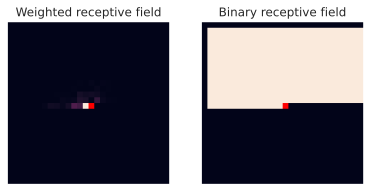

In [112]:
test_model = PixelCNN(c_in=1, c_hidden=64)
inp = torch.zeros(1,1,28,28) # 空的map
inp.requires_grad_() # 更新inp
out = test_model(inp)
show_center_recep_field(inp, out.squeeze(dim=2))
del inp, out, test_model

- 上图表示了，为了预测any像素，我们**可以考虑(理论上)**几乎一半的图像。
    - but “理论”的感受野不一定是有效的感受野，后者通常要小得多。
- 因此，对于一个更强的模型，我们应该尝试**进一步增加接受野**。特别是，对于**右下角的像素，最后一个像素，我们可以考虑整个图像**。
- 然而，我们目前的接受野只跨越了图像的1/4。

编码器-解码器架构可以帮助解决这个问题【？】，但它也表明，在自回归模型中，我们需要比在vae或基于能量的模型中nucher Deeper and more complex的网络。

In [94]:
from pytorch_lightning.loggers import TensorBoardLogger
logger_tr = TensorBoardLogger(
    save_dir=os.path.join(CHECKPOINT_PATH, "PixelCNN"),
)
# Create a PyTorch Lightning trainer with the generation callback
trainer = pl.Trainer(
    logger=logger_tr,
    #default_root_dir=os.path.join(CHECKPOINT_PATH, "PixelCNN"),
                        strategy='auto',accelerator="gpu" ,
                        devices=1,
                        max_epochs=150,
                        callbacks=[
                            ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_bpd"),
                                LearningRateMonitor("epoch")],
                        )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [96]:
result = None
# Check whether pretrained model exists. If yes, load it and skip training
pretrained_filename = os.path.join(CHECKPOINT_PATH, "PixelCNN.ckpt")
if os.path.isfile(pretrained_filename):
    print("Found pretrained model, loading...")
    model = PixelCNN.load_from_checkpoint(pretrained_filename)
    ckpt = torch.load(pretrained_filename, map_location=device)
    result = ckpt.get("result", None)
else:
    model = PixelCNN(c_in=1,c_hidden=64)
    trainer.fit(model, train_loader, val_loader)
model = model.to(device)

if result is None:
    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result, "val": val_result}

Lightning automatically upgraded your loaded checkpoint from v0.9.0 to v2.0.0. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint --file saved_models/tutorial12/PixelCNN.ckpt`


Found pretrained model, loading...


In [98]:
test_res = result["test"][0]
print("Test bits per dimension: %4.3fbpd" % (test_res["test_loss"] if "test_loss" in test_res else test_res["test_bpd"]))

Test bits per dimension: 0.808bpd


PixelCNN的测试性能为0.809bpd，显著优于我们在教程11中看到的归一化流。将图像建模视为一个自回归问题，简化了学习过程，因为在给定所有其他像素的基本事实的情况下预测一个像素比一次性预测所有像素要容易得多。此外，PixeICNN可以通过离散的softmax显式预测像素值，而Normalizing Flows必须学习连续潜在空间中的转换。这两个方面使得PixelCNN获得了明显更好的性能。为了充分比较模型，让我们也测量PixelCNN的参数数量:

In [99]:
num_params = sum([np.prod(param.shape) for param in model.parameters()])
print("Number of parameters: {:,}".format(num_params))

Number of parameters: 852,160


与多尺度归一化流相比，PixelCNN的参数要少得多。当然，参数的数量只取决于我们的超参数选择。然而，总的来说，可以这么说，基于上述原因，自回归模型需要比正规化流更少的参数来达到良好的性能。然而，自回归模型在采样方面比正规化流慢得多，这限制了它们可能的应用。

Global seed set to 1


  0%|          | 0/28 [00:00<?, ?it/s]

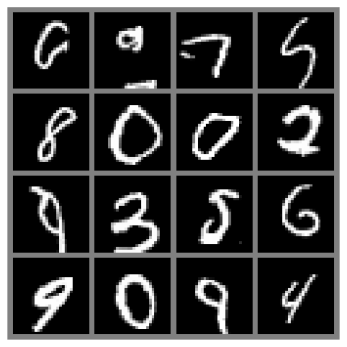

In [100]:
pl.seed_everything(1)
samples = model.sample(img_shape=(16,1,28,28))
show_imgs(samples.cpu())

大多数样本都可以被识别为数字，总的来说，我们获得了比规范化流更好的质量。这与我们使用自回归模型获得的低可能性相一致。尽管如此，我们也看到仍有改进的地方，因为相当多的样本无法识别(例如第一行)。更深层次的自回归模型有望获得更好的质量，因为它们可以在生成像素时考虑更多的上下文。

训练过的模型本身不受任何特定图像大小的限制。然而，如果我们实际上对一个比我们在训练数据集中看到的更大的图像进行采样，会发生什么?让我们尝试下面的64 × 64而不是28 × 28的图像样本:

Global seed set to 1


  0%|          | 0/64 [00:00<?, ?it/s]

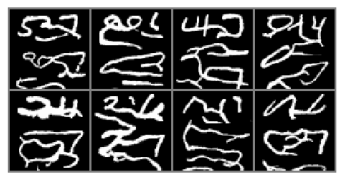

In [101]:
pl.seed_everything(1)
samples = model.sample(img_shape=(8,1,64,64))
show_imgs(samples.cpu())

较大的图像表明，在测试期间改变图像的大小会使模型混乱，并生成抽象的图形(有时可以在左上角发现一个数字)。此外，在GPU上对64x64像素的图像进行采样需要超过一分钟。显然，自回归模型不能在不改变采样程序(如预测)的情况下缩放到大图像。我们的实现也不是最有效的，因为许多计算可以在整个采样过程中存储和重用。尽管如此，采样过程仍然是连续的，这本质上比在规范化流中所做的并行生成慢。

## 自动补全


自回归模型的一个常见应用是自动补全图像。由于自回归模型一个一个地预测像素，我们可以将前N个像素设置为预定义值，并检查模型如何完成图像。为了实现这一点，我们只需要跳过迭代在采样循环中已经有一个不等于-1的值。具体实现请参见上面的PyTorch Lightning模块。在细胞里下面，我们从训练集中随机抽取三张图像，对图像的下半部分进行遮罩，并让模型自动完成。去看样本的多样性，我们对每张图像做12次:

Original image and input image to sampling:


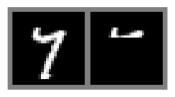

Global seed set to 1


  0%|          | 0/28 [00:00<?, ?it/s]

Autocompletion samples:


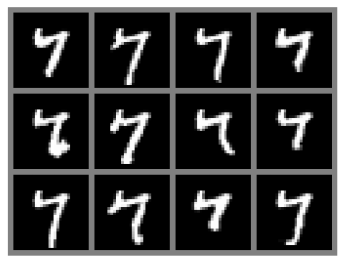

Original image and input image to sampling:


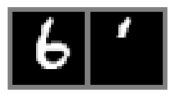

Global seed set to 1


  0%|          | 0/28 [00:00<?, ?it/s]

Autocompletion samples:


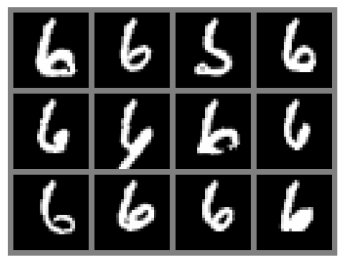

Original image and input image to sampling:


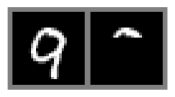

Global seed set to 1


  0%|          | 0/28 [00:00<?, ?it/s]

Autocompletion samples:


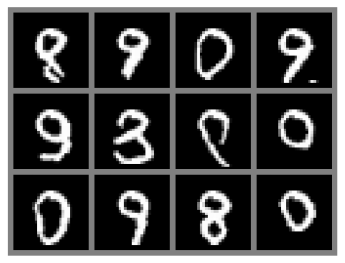

In [102]:
def autocomplete_image(img):
    # Remove lower half of the image
    img_init = img.clone()
    img_init[:,10:,:] = -1
    print("Original image and input image to sampling:")
    show_imgs([img,img_init])
    # Generate 12 example completions
    img_init = img_init.unsqueeze(dim=0).expand(12,-1,-1,-1).to(device)
    pl.seed_everything(1)
    img_generated = model.sample(img_init.shape, img_init)
    print("Autocompletion samples:")
    show_imgs(img_generated)

for i in range(1,4):
    img = train_set[i][0]
    autocomplete_image(img)

对于前两位数字(7和6)，我们看到12个样本的结果都与原始数字相似。然而，在写7和一些变形的6的样本中，有一些风格上的差异。当自动补全下面的9时，我们看到模型可以适合多个数字。我们从0、3、8和9中得到不同的样本。这说明在没有潜在空间的情况下，我们仍然可以从自回归模型中获得不同的样本。

## 预测分布的可视化(softmax)

- 自回归模型使用256个softmax来预测下一个像素。这使模型具有很大的灵活性，因为每个像素值的概率可以在必要时独立学习。
- 但是，这些值实际上**并不是独立的**，因为**值32和33比32和255更接近**。
- 在下面，我们可视化模型预测的softmax分布，以了解它是如何学习附近像素的关系的。

1. 可视化训练数据集上像素分布
2. 在一批图像上run model，并存储输出的softmax分布；然后可视化我们的模型预测的(平均)分布


#### 数据集上像素分布

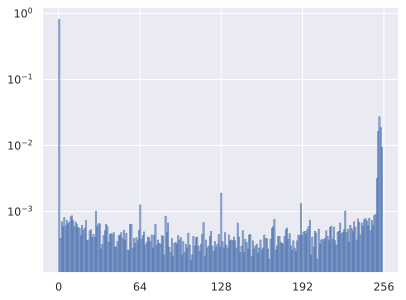

In [105]:
sns.set()
plot_args = {"color": to_rgb("C0")+(0.5,), "edgecolor": "C0", "linewidth": 0.5, "width": 1.0}
plt.hist(imgs.view(-1).cpu().numpy(), bins=256, density=True, **plot_args)
plt.yscale("log")
plt.xticks([0,64,128,192,256])
plt.show()
plt.close()

- 正如我们所看到的图像所期望的那样，像素值O(黑色)是主导值，其次是250到255之间的一批值。
    - 我们在y轴上使用对数刻度因为数据集中存在很大的不平衡。
- 有趣的是，像素值64、128和191也很突出，**可能是由于在创建数据集期间使用的量化**。
- 对于RGB图像，我们也会在O和255附近看到两个峰值，但是介于两者之间的值将比MNIST中频繁得多(参见pixelcnn++中的图1，以获得CIFAR10上的可视化)。

#### 模型预测的(平均)分布

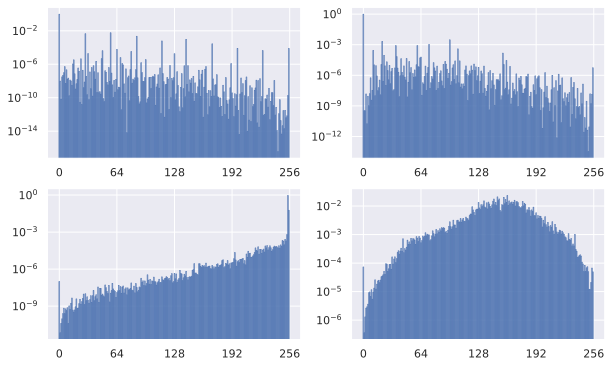

In [106]:
det_loader = data.DataLoader(train_set, batch_size=128, shuffle=False, drop_last=False)
imgs,_ = next(iter(det_loader))
imgs = imgs.to(device)
with torch.no_grad():
    out = model(imgs)
    out = F.softmax(out, dim=1)
    mean_out = out.mean(dim=[0,2,3,4]).cpu().numpy()
    out = out.cpu().numpy()

fig, ax = plt.subplots(2,2, figsize=(10,6))

# 四个样本的pixels预测分布
for i in range(4):
    ax_sub = ax[i//2][i%2]
    ax_sub.bar(np.arange(out.shape[1], dtype=np.int32), out[i+4,:,0,14,14], **plot_args)
    ax_sub.set_yscale("log")
    ax_sub.set_xticks([0,64,128,192,256])
plt.show()
plt.close()

- 总的来说，我们看到了一个非常多样化的分布集，0通常有一个峰值，接近1。
- 但是，第一行中的分布显示了一个**潜在的不好行为**。例如，**值242的可能性比243低1000倍，尽管它们非常接近，通常无法区分**。
- 这表明该模型可能没有很好地泛化像素值。更好的解决方案是使用**discrete logistic distribution而不是softmax distribution**。

一个离散的逻辑分布可以被想象成离散的、binned的高斯分布。使用离散Gaussian的mixture而不是softmax引入了一个**归纳偏差的模型**，以分配接近值相似的可能性。我们可以看到一个离散的logitstic如下:

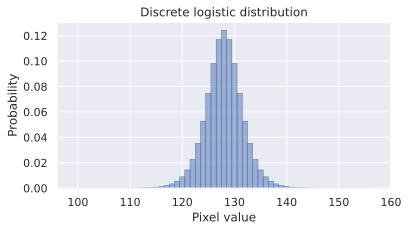

In [107]:
mu = torch.Tensor([128])
sigma = torch.Tensor([2.0])

def discrete_logistic(x, mu, sigma):
    return torch.sigmoid((x+0.5-mu)/sigma) - torch.sigmoid((x-0.5-mu)/sigma)

x = torch.arange(256)
p = discrete_logistic(x, mu, sigma)

# Visualization
plt.figure(figsize=(6,3))
plt.bar(x.numpy(), p.numpy(), **plot_args)
plt.xlim(96,160)
plt.title("Discrete logistic distribution")
plt.xlabel("Pixel value")
plt.ylabel("Probability")
plt.show()
plt.close()

- 该模型将输出我们在混合物中使用的K logistics的平均值和标准差，而不是softmax。
- 这是PixelCNN++[3]引入的自回归模型相对于原始PixelCNN的改进之一。

[3]Salimans, Tim, et al. “PixelCNN++: Improving the PixelCNN with Discretized Logistic Mixture Likelihood and Other Modifications.” arXiv preprint arXiv:1701.05517 (2017)

### summary

- 在本教程中，我们已经研究了自回归图像建模，并实现了PixelCNN架构。
    - 通过使用掩码卷积，我们能够应用一个卷积网络，其中一个像素只受其所有前一个像素的影响。将mask卷积分离为水平和垂直stack，使我们能够去除像素右上行上的已知盲点。
    - 在实验中，自回归模型在每维位数方面优于归一化流，但从其中**采样要慢得多**。
- 我们在这里没有实现的改进是离散逻辑混合分布、下采样架构和以对角线方式改变像素顺序(参见PixelSNAIL)。
- 总的来说，自回归模型是另一个强大的生成模型家族，然而，由于它们在**采样时间上的线性cale而不是图像上的二次scale**，因此它主要用于序列任务。